In [ ]:
#|hide
#| nbflags skip_exec skip_showdoc

# Examples on how to use tiling utilities

## Tiling dataset for object detection or instance segmentation

In [ ]:
from pathlib import Path
from drone_detector.processing.tiling import *
import os, sys
import geopandas as gpd
import rasterio as rio
from rasterio import plot as rioplot
import random
import matplotlib.pyplot as plt

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This example uses deadwood data from Hiidenportti. For this purpose, we use only 5 tiles to speed things up.

In [ ]:
tile_folder = Path('../../data/raw/hiidenportti/virtual_plots/train/images/')
vector_folder = Path('../../data/raw/hiidenportti/virtual_plots/train/vectors/')

outpath = Path('../data/hiidenportti/processed_example/')

tiles = sorted(os.listdir(tile_folder))[:5]
vectors = sorted([f for f in os.listdir(vector_folder) if f.endswith('geojson')])[:5]
assert len(tiles) == len(vectors)

These virtual plots are tiled into 512 times 512 pixel grid. Then, the vector files are tiled using the same grid. By setting `min_area_pct` to 0.25, we discard all polygons that are cut so that their area is less than 25% of the original area. `Tiler.tile_vector` discards all grid cells that don't contain any polygons

In [ ]:
for t in tiles:
    if not os.path.exists(outpath/t[:-4]): os.makedirs(outpath/t[:-4])
    shp_fname = t.replace('tif', 'geojson')
    tilesize = 512
    tiler = Tiler(outpath=outpath/t[:-4], gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
    tiler.tile_raster(str(tile_folder/t))
    tiler.tile_vector(vector_folder/shp_fname, min_area_pct=0.25)

25it [00:00, 73.64it/s]
16it [00:00, 38.62it/s]
25it [00:00, 76.25it/s]
16it [00:00, 31.12it/s]
54it [00:00, 62.43it/s]
40it [00:00, 43.92it/s]
132it [00:02, 54.29it/s]
110it [00:02, 41.22it/s]
25it [00:00, 75.48it/s]
16it [00:00, 41.42it/s]


In [ ]:
for d in os.listdir(outpath):
    print(f"""{d} was split into {len(os.listdir(outpath/d/'raster_tiles'))} raster cells and {len(os.listdir(outpath/d/"vector_tiles"))} vector cells""")

104_111_Hiidenportti_Chunk4_orto was split into 16 raster cells and 16 vector cells
104_18_Hiidenportti_Chunk5_orto was split into 16 raster cells and 15 vector cells
104_118_Hiidenportti_Chunk6_orto was split into 40 raster cells and 35 vector cells
104_16_Hiidenportti_Chunk5_orto was split into 110 raster cells and 108 vector cells
104_102_Hiidenportti_Chunk9_orto was split into 16 raster cells and 16 vector cells


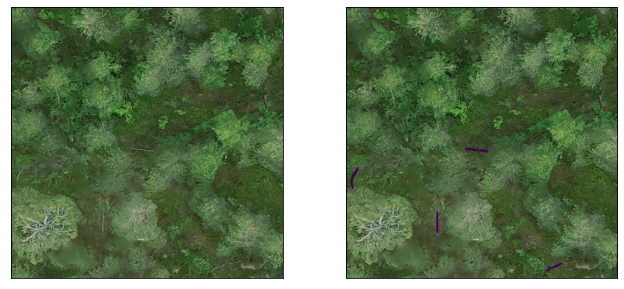

In [ ]:
ex_file = random.sample(os.listdir(outpath/d/'vector_tiles'), 1)[0]
fig, axs = plt.subplots(1,2, figsize=(11,5))
for a in axs:
    a.set_xticks([])
    a.set_yticks([])
with rio.open(outpath/d/f"raster_tiles/{ex_file.replace('geojson', 'tif')}") as im:
    rioplot.show(im, ax=axs[0])
    mask = gpd.read_file(outpath/d/'vector_tiles'/ex_file)
    rioplot.show(im, ax=axs[1])
    mask.plot(ax=axs[1], column='groundwood')

## Tiling dataset for semantic segmentation

In [ ]:
outpath = Path('../data/hiidenportti/processed_unet_example/')

tiles = sorted(os.listdir(tile_folder))[:5]
vectors = sorted([f for f in os.listdir(vector_folder) if f.endswith('geojson')])[:5]
assert len(tiles) == len(vectors)

For semantic segmentation, we split the data into 256 times 256 pixel grid. Vector files are then tiled and rasterized to the same grid, in such way that raster images are saved. This method saves target mask for each cell even if they don't contain any masks. 

In [ ]:
for t in tiles:
    if not os.path.exists(outpath/t[:-4]): os.makedirs(outpath/t[:-4])
    shp_fname = t.replace('tif', 'geojson')
    tilesize = 256
    tiler = Tiler(outpath=outpath/t[:-4], gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
    tiler.tile_raster(str(tile_folder/t))
    tiler.tile_and_rasterize_vector(tile_folder/t, vector_folder/shp_fname, column='groundwood')

81it [00:00, 137.19it/s]
64it [00:01, 54.68it/s]
81it [00:00, 145.42it/s]
64it [00:01, 43.21it/s]
187it [00:03, 54.60it/s]
160it [00:03, 51.94it/s]
483it [00:03, 129.74it/s]
440it [00:18, 24.27it/s]
81it [00:00, 145.25it/s]
64it [00:01, 56.46it/s]


In [ ]:
for d in os.listdir(outpath):
    print(f"""{d} was split into {len(os.listdir(outpath/d/'raster_tiles'))} raster cells and {len(os.listdir(outpath/d/"rasterized_vector_tiles"))} vector cells""")

104_111_Hiidenportti_Chunk4_orto was split into 64 raster cells and 64 vector cells
104_18_Hiidenportti_Chunk5_orto was split into 64 raster cells and 64 vector cells
104_118_Hiidenportti_Chunk6_orto was split into 160 raster cells and 160 vector cells
104_16_Hiidenportti_Chunk5_orto was split into 440 raster cells and 440 vector cells
104_102_Hiidenportti_Chunk9_orto was split into 64 raster cells and 64 vector cells


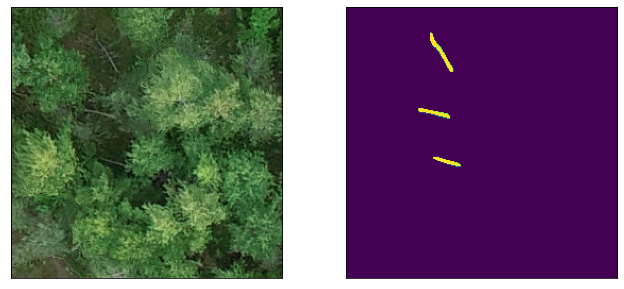

In [ ]:
ex_file = random.sample(os.listdir(outpath/d/'rasterized_vector_tiles'), 1)[0]
fig, axs = plt.subplots(1,2, figsize=(11,5))
for a in axs:
    a.set_xticks([])
    a.set_yticks([])
with rio.open(outpath/d/"raster_tiles"/ex_file) as im:
    rioplot.show(im, ax=axs[0])
with rio.open(outpath/d/"rasterized_vector_tiles"/ex_file) as mask:
    rioplot.show(mask, ax=axs[1])


## Tiling non-geospatial data

So far `Tiler` doesn't really support data without sensible geotransform. It is, however, possible to work around and might be available in the future.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
map_tile = '../data/historic_map/raw/kartta.png'
mask_tile = '../data/historic_map/raw/swampbin.png'
outpath = Path('../data/historic_map/processed')

In [ ]:
tilesize = 224
map_tiler = Tiler(outpath=outpath, gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
map_tiler.tile_raster(map_tile)

378it [00:10, 37.79it/s]


In [ ]:
from osgeo import gdal

We have to manually set pixel coordinates as geocoordinates, provide GCPs and change the order of `projWin`

In [ ]:
raster = gdal.Open(map_tile)
for row in (map_tiler.grid.itertuples()):
    coords = list(row.geometry.exterior.coords)[:-1]
    gcp_list = []
    gcp_list.append(gdal.GCP(coords[0][0],coords[0][1],1,0,-0))
    gcp_list.append(gdal.GCP(coords[1][0],coords[1][1],1,224,-0))
    gcp_list.append(gdal.GCP(coords[2][0],coords[2][1],1,224,-224))
    gcp_list.append(gdal.GCP(coords[3][0],coords[3][1],1,0,-224))
    translate_kwargs = {'GCPs': gcp_list}
    tempraster = gdal.Translate(f'{map_tiler.raster_path}/{row.cell}.tif', raster,
                                projWin=[row.geometry.bounds[0], row.geometry.bounds[1], 
                                         row.geometry.bounds[2], row.geometry.bounds[3]],
                                **translate_kwargs
                               )
    tempraster = None
raster = None

In [ ]:
map_tiler.raster_path = outpath/'mask_tiles'
map_tiler.tile_raster(mask_tile)

378it [00:04, 93.63it/s] 


In [ ]:
raster = gdal.Open(mask_tile)
for row in (map_tiler.grid.itertuples()):
    coords = list(row.geometry.exterior.coords)[:-1]
    gcp_list = []
    gcp_list.append(gdal.GCP(coords[0][0],coords[0][1],1,0,-0))
    gcp_list.append(gdal.GCP(coords[1][0],coords[1][1],1,224,-0))
    gcp_list.append(gdal.GCP(coords[2][0],coords[2][1],1,224,-224))
    gcp_list.append(gdal.GCP(coords[3][0],coords[3][1],1,0,-224))
    translate_kwargs = {'GCPs': gcp_list,
                        'outputType': gdal.GDT_Byte}
    tempraster = gdal.Translate(f'{map_tiler.raster_path}/{row.cell}.tif', raster,
                                projWin=[row.geometry.bounds[0], row.geometry.bounds[1], 
                                         row.geometry.bounds[2], row.geometry.bounds[3]],
                                **translate_kwargs
                               )
    tempraster = None
raster = None

Example data here is historical map from Evo area, and the target mask is for marshes and swamps.

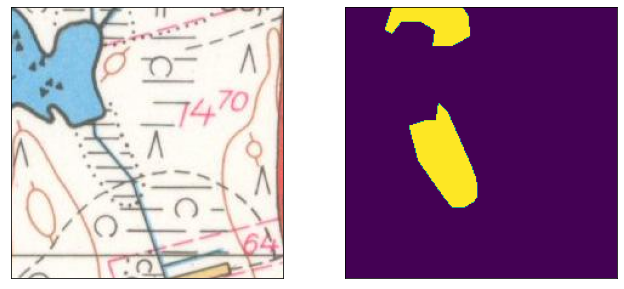

In [ ]:
ex_file = random.sample(os.listdir(outpath/'raster_tiles'), 1)[0]
fig, axs = plt.subplots(1,2, figsize=(11,5))
for a in axs:
    a.set_xticks([])
    a.set_yticks([])
with rio.open(outpath/"raster_tiles"/ex_file) as im:
    rioplot.show(im, ax=axs[0])
with rio.open(outpath/"mask_tiles"/ex_file) as mask:
    rioplot.show(mask, ax=axs[1])
